<a href="https://colab.research.google.com/github/srikarraju/ADL/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets.mnist import load_data

(trainX, trainY), (testX, testY) = load_data()

print('Train', trainX.shape, trainY.shape)
print('Test', testX.shape, testY.shape)

11493376/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [ ]:
import numpy as np
def make_samples_3D(arr):
	X = np.expand_dims(arr, axis=-1)
	X = X.astype('float32')
	X = X / 255.0
	return X

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
trainX_Gan ,testX_Gan, trainY_Gan, testY_Gan = train_test_split(trainX,trainY,train_size = 10000,random_state = 10)
class_count = np.zeros(10,dtype=int)
for i in range(len(trainY_Gan)):
  class_count[trainY_Gan[i]] += 1
print(class_count)

[ 989 1167  942  993  992  870  996 1056  994 1001]


In [ ]:
## Building a GAN
from keras.layers import Conv2D,LeakyReLU,Dropout,Flatten,Dense
from keras.models import Sequential
from keras.optimizers import Adam
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
from numpy.random import rand,randint, randn
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [ ]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
from keras.layers import Reshape, Conv2DTranspose, Conv2D
from keras.utils.vis_utils import plot_model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
def generate_samples_from_generator(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [ ]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	print(dataset.shape)
	half_batch = int(n_batch / 2)
	#print("GAN Training Started")
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			X_fake, y_fake = generate_samples_from_generator(g_model, latent_dim, half_batch)
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			d_loss, _ = d_model.train_on_batch(X, y)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)

trainX = []
for i in range(len(trainY_Gan)):
  if trainY_Gan[i] ==3:
    trainX.append(trainX_Gan[i])
trainX = make_samples_3D(trainX)
gan_model = define_gan(g_model, d_model)
#gan_model.summary()
#plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)
train(g_model, d_model, gan_model,trainX, latent_dim,n_batch=50)

(993, 28, 28, 1)
>1, 1/19, d=0.689, g=0.730
>1, 2/19, d=0.686, g=0.764
>1, 3/19, d=0.684, g=0.771
>1, 4/19, d=0.669, g=0.782
>1, 5/19, d=0.655, g=0.803
>1, 6/19, d=0.665, g=0.804
>1, 7/19, d=0.648, g=0.816
>1, 8/19, d=0.652, g=0.835
>1, 9/19, d=0.642, g=0.828
>1, 10/19, d=0.644, g=0.835
>1, 11/19, d=0.639, g=0.822
>1, 12/19, d=0.644, g=0.807
>1, 13/19, d=0.650, g=0.778
>1, 14/19, d=0.647, g=0.761
>1, 15/19, d=0.658, g=0.744
>1, 16/19, d=0.661, g=0.729
>1, 17/19, d=0.651, g=0.721
>1, 18/19, d=0.655, g=0.715
>1, 19/19, d=0.644, g=0.711
>2, 1/19, d=0.640, g=0.706
>2, 2/19, d=0.639, g=0.704
>2, 3/19, d=0.625, g=0.704
>2, 4/19, d=0.622, g=0.703
>2, 5/19, d=0.622, g=0.703
>2, 6/19, d=0.606, g=0.703
>2, 7/19, d=0.603, g=0.702
>2, 8/19, d=0.597, g=0.703
>2, 9/19, d=0.599, g=0.702
>2, 10/19, d=0.568, g=0.702
>2, 11/19, d=0.568, g=0.703
>2, 12/19, d=0.560, g=0.703
>2, 13/19, d=0.563, g=0.703
>2, 14/19, d=0.547, g=0.704
>2, 15/19, d=0.545, g=0.703
>2, 16/19, d=0.531, g=0.704
>2, 17/19, d=0.524, g

In [ ]:
from matplotlib import pyplot
latent_dim = 100
model = define_generator(latent_dim)
n_samples = 1
X, _ = generate_samples_from_generator(model, latent_dim, n_samples)

# print(X.shape)
# trainX = np.concatenate((trainX,X))
# print(trainX.shape)
# print(X)
# for i in range(n_samples):
# 	#pyplot.subplot(5, 5, 1 + i)
# 	pyplot.axis('off')
# 	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# pyplot.show()

In [ ]:
from keras.models import load_model

filename = "/content/drive/MyDrive/Colab Notebooks/ADL/ADL_2/models/generator_model_label"+str(3)
model2 = load_model(filename)
n_samples = 1
latent_points = generate_latent_points(100, n_samples)
X = model2.predict(latent_points)

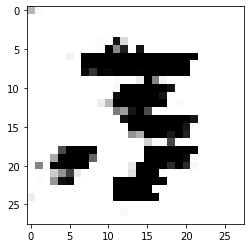

In [ ]:
#sample1 = np.concatenate((sample1,X),axis=0)
#print(sample1.shape)
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/ADL/ADL_2/models/generator_model_label3'
g_model.save(filename)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/ADL/ADL_2/models/generator_model_label3/assets


In [ ]:
label7_samples = []
for i in range(len(trainY_Gan)):
  if trainY_Gan[i]==7:
    label7_samples.append(trainX_Gan_new[i])
label7_samples = np.asarray(label7_samples)

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

In [ ]:
from keras.models import load_model

syn_train_set = []
syn_set_labels = []
num_samples = 300
for i in range(10):
  filename = "/content/drive/MyDrive/Colab Notebooks/ADL/ADL_2/models/generator_model_label"+str(i)
  model = load_model(filename)
  latent_points = generate_latent_points(100, num_samples)
  X = model.predict(latent_points)
  if i==0:
    syn_train_set = X
  else:
    syn_train_set = np.concatenate((syn_train_set,X),axis=0)
  syn_set_labels += [i]*num_samples
trainY_syn = np.asarray(syn_set_labels)
trainX_syn = syn_train_set
#save_plot(X, 5)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
trainX_final ,testX_final, trainY_final, testY_final = train_test_split(testX_Gan,testY_Gan,train_size = 1000,random_state = 10)
class_count = np.zeros(10,dtype=int)
for i in range(len(trainY_final)):
  class_count[trainY_final[i]] += 1
print(class_count)

[ 972 1121 1034 1063  983  898  976 1046  953  954]


In [ ]:
print(trainX_syn.shape)
model = mnist_classifier()
#print(model.summary())
model.fit(trainX_syn,trainY_syn,epochs =2)

testX_new = make_samples_3D(testX)
print(testX_new.shape)
print(model.evaluate(testX_new,testY))

(500, 28, 28, 1)
Epoch 1/2
16/16 [==============================] - 0s 5ms/step - loss: 1.3216 - accuracy: 0.5637
Epoch 2/2
16/16 [==============================] - 0s 5ms/step - loss: 0.0495 - accuracy: 0.9866
(10000, 28, 28, 1)
313/313 [==============================] - 1s 2ms/step - loss: 1.7568 - accuracy: 0.5975
[1.756816029548645, 0.5975000262260437]


In [ ]:
trainX_Gan_,testX_Gan_, trainY_Gan_, testY_Gan_ = train_test_split(testX_Gan,testY_Gan,train_size = 1000,random_state = 10)

In [ ]:
trainX_Gan_new = make_samples_3D(trainX_Gan_)
print(trainX_Gan_new.shape)
model = mnist_classifier()
#print(model.summary())
model.fit(trainX_Gan_new,trainY_Gan_,epochs =2)

testX_new = make_samples_3D(testX)
print(testX_new.shape)
print(model.evaluate(testX_new,testY))

(1000, 28, 28, 1)
Epoch 1/2
32/32 [==============================] - 1s 5ms/step - loss: 1.5108 - accuracy: 0.5250
Epoch 2/2
32/32 [==============================] - 0s 6ms/step - loss: 0.5428 - accuracy: 0.8371
(10000, 28, 28, 1)
313/313 [==============================] - 1s 2ms/step - loss: 1.7890 - accuracy: 0.6958
[1.7889609336853027, 0.6958000063896179]


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Flatten,Softmax,LeakyReLU,Dense
from keras.optimizers import Adam
from keras.initializers import he_normal
def mnist_classifier(in_shape=(28,28,1)):
	model = Sequential()
	#model.add(Flatten(input_shape=in_shape))
	model.add(Conv2D(32, (3,3), strides=(2, 2), input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.4))
	model.add(Dropout(0.4))
	# model.add(Conv2D(64, (3,3), strides=(2, 2)))
	# model.add(LeakyReLU(alpha=0.2))
	# model.add(Dropout(0.6))
	model.add(Flatten())
	#model.add(Dense(500,activation='sigmoid'))
	model.add(Dense(10,activation='softmax'))
	opt = Adam(lr=0.03, beta_1=0.5)
	model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
train_2000_X = np.concatenate((trainX_Gan_new,trainX_syn),axis=0)
train_2000_Y = np.concatenate((trainY_Gan_,trainY_syn),axis=0)

print(train_2000_X.shape)
model = mnist_classifier()
model.fit(train_2000_X,train_2000_Y,epochs =2)

testX_new = make_samples_3D(testX)
print(testX_new.shape)
print(model.evaluate(testX_new,testY))

(4000, 28, 28, 1)
Epoch 1/2
125/125 [==============================] - 1s 5ms/step - loss: 0.7625 - accuracy: 0.8082
Epoch 2/2
125/125 [==============================] - 1s 5ms/step - loss: 0.4783 - accuracy: 0.9431
(10000, 28, 28, 1)
313/313 [==============================] - 1s 2ms/step - loss: 1.8688 - accuracy: 0.7857
[1.8687824010849, 0.7857000231742859]


In [ ]:
#RECURSIVE TRAINING
trainX_rec,_, trainY_rec,_ = train_test_split(testX_Gan,testY_Gan,train_size = 1000,random_state = 10)
trainX_rec = make_samples_3D(trainX_rec)

model = mnist_classifier()
model.fit(trainX_rec,trainY_rec,epochs=2)

print(model.evaluate(testX_new,testY))

latent_dim = 100


rec_X = trainX_rec
rec_Y = trainY_rec

for i in range(10):
  for j in range(10):
    train_gen = []
    for k in range(len(trainY_rec)):
      if trainY_rec[k] == j:
        train_gen.append(trainX_rec[k])
    train_gen = np.asarray(train_gen)
    d_model = define_discriminator()
    g_model = define_generator(latent_dim)
    gan_model = define_gan(g_model, d_model)
    train(g_model, d_model, gan_model, train_gen, latent_dim,n_batch=10,n_epochs=100)
    latent_points = generate_latent_points(100, 20)
    X = g_model.predict(latent_points)
    Y = [j]*20
    Y = np.asarray(Y)
    rec_X = np.concatenate((rec_X,X),axis = 0)
    rec_Y = np.concatenate((rec_Y,Y),axis = 0)
  trainX_rec = rec_X
  trainY_rec = rec_Y
  print(trainX_rec.shape)
  model.fit(trainX_rec,trainY_rec,epochs =2)
  print(model.evaluate(testX_new,testY))

Epoch 1/2
32/32 [==============================] - 0s 5ms/step - loss: 1.5161 - accuracy: 0.5116
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 1.2825 - accuracy: 0.7919
[1.2824546098709106, 0.7918999791145325]
(91, 28, 28, 1)
GAN Training Started
GAN Training Done
(129, 28, 28, 1)
GAN Training Started
GAN Training Done
(102, 28, 28, 1)
GAN Training Started
GAN Training Done
(104, 28, 28, 1)
GAN Training Started
GAN Training Done
(106, 28, 28, 1)
GAN Training Started
GAN Training Done
(88, 28, 28, 1)
GAN Training Started
GAN Training Done
(97, 28, 28, 1)
GAN Training Started
GAN Training Done
(114, 28, 28, 1)
GAN Training Started
GAN Training Done
(82, 28, 28, 1)
GAN Training Started
GAN Training Done
(87, 28, 28, 1)
GAN Training Started
GAN Training Done
(1200, 28, 28, 1)
Epoch 1/2
38/38 [==============================] - 0s 7ms/step - loss: 0.4199 - accuracy: 0.8950
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 0.9984 - accuracy: 0

In [ ]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
print(type(trainY_rec))

<class 'numpy.ndarray'>
